In [1]:
import numpy as np
import ROOT
from math import exp as expo
from math import cos as cosine
exp=np.vectorize(expo)
cos=np.vectorize(cosine)
import matplotlib.pylab as plt
from matplotlib.pyplot import figure
from BlindersPy3 import Blinders
from BlindersPy3 import FitType
import scipy.optimize as opt

Welcome to JupyROOT 6.24/06


In [2]:
file = ROOT.TFile.Open("run2_4hcopy_ratioFR_cov_mat_tim.root")
#direc = file.Get("QFillByFillAnalyzerDB")
hist = ROOT.TH1D()
hist = file.Get("calo_histogram_sum_ratio")
hcov = ROOT.TH2D()
hcov = file.Get("hcov")

In [3]:
getBlinded = Blinders(FitType.Omega_a, "Ritwika's new  Blinding")

 + ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ +
 +                                                                      +
 +           You have chose to blind your fitting according to          +
 +                omega_ref * (1 + (R +/- deltaR) *10^{-6})             +
 +                                                                      +
 + ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ +


In [4]:
fit_start=30000
fit_stop=300000
fit_range=hist.FindBin(fit_stop)-hist.FindBin(fit_start)+1

T_a_true=4365.411
nbinshift=int((0.5*T_a_true)/hist.GetBinWidth(1))
T_a=2*nbinshift*hist.GetBinWidth(1)

y_val=np.empty(fit_range)
y_err=np.empty(fit_range)
x_val=np.empty(fit_range)

for ibin in range (0,fit_range):
    y_val[ibin]=hist.GetBinContent(ibin+hist.FindBin(fit_start))
    y_err[ibin]=hist.GetBinError(ibin+hist.FindBin(fit_start))
    x_val[ibin]=hist.GetBinCenter(ibin+hist.FindBin(fit_start))

y_cov = np.empty(shape=(fit_range,fit_range))

for irow in range (0, fit_range):
      for icol in range(0, fit_range):
            y_cov[irow][icol]=hcov.GetBinContent(irow+hist.FindBin(fit_start),icol+hist.FindBin(fit_start))

In [5]:
print(y_cov[0][0])
mat=np.linalg.eigvalsh(y_cov)
for irow in range (0, fit_range):
    if mat[irow]<=0:
        print(irow,"\n")

5.60463000595432e-09


In [6]:
def fit_func(time: np.double,
             asym: np.double = 0.0, 
             R: np.double = 0.0, 
             phi: np.double = 0.0,
             asym_cbo = 0.0,
             tau_cbo = 0.0,
             omega_cbo = 0.0,
             phi_cbo = 0.0,
             asym_cbo_A = 0.0,
             phi_cbo_A=0.0,
             A_cbo_phi= 0.0,
             phi_cbo_phi=0.0,
             asym_vw= 0.0,
             tau_vw = 0.0,
             omega_vw = 0.0,
             phi_vw = 0.0,
             asym_vbo= 0.0,
             tau_vbo = 0.0,
             omega_vbo = 0.0,
             phi_vbo = 0.0,
             asym_2cbo= 0.0,
             tau_2cbo = 0.0,
             omega_2cbo = 0.0,
             phi_2cbo = 0.0)-> np.double:
    
    Ncbo=(1 + asym_cbo*exp(-time/tau_cbo)*cos(omega_cbo*time - phi_cbo))
    Ncbof=(1+ asym_cbo*exp(-(time + T_a/2)/tau_cbo)*cos(omega_cbo*(time + T_a/2) - phi_cbo))
    Ncbob=(1+ asym_cbo*exp(-(time - T_a/2)/tau_cbo)*cos(omega_cbo*(time - T_a/2) - phi_cbo))
    Acbo=(1+ asym_cbo_A*exp(-time/tau_cbo)*cos(omega_cbo*time - phi_cbo_A));
    Acbof=(1+ asym_cbo_A*exp(-(time + T_a/2)/tau_cbo)*cos(omega_cbo*(time + T_a/2) - phi_cbo_A))
    Acbob=(1+ asym_cbo_A*exp(-(time - T_a/2)/tau_cbo)*cos(omega_cbo*(time - T_a/2) - phi_cbo_A))
    phicbo=(A_cbo_phi*exp(-time/tau_cbo)*cos(omega_cbo*time - phi_cbo_phi))
    phicbof=(A_cbo_phi*exp(-(time + T_a/2)/tau_cbo)*cos(omega_cbo*(time + T_a/2) - phi_cbo_phi))
    phicbob=(A_cbo_phi*exp(-(time - T_a/2)/tau_cbo)*cos(omega_cbo*(time - T_a/2) - phi_cbo_phi))
    Nvw=(1+ asym_vw*exp(-time/tau_vw)*cos(omega_vw*time - phi_vw))
    Nvwf=(1+ asym_vw*exp(-(time + T_a/2)/tau_vw)*cos(omega_vw*(time + T_a/2) - phi_vw))
    Nvwb=(1+ asym_vw*exp(-(time - T_a/2)/tau_vw)*cos(omega_vw*(time - T_a/2) - phi_vw))
    Nvbo=(1+ asym_vbo*exp(-time/tau_vbo)*cos(omega_vbo*time - phi_vbo))
    Nvbof=(1+ asym_vbo*exp(-(time + T_a/2)/tau_vbo)*cos(omega_vbo*(time + T_a/2) - phi_vbo))
    Nvbob=(1+ asym_vbo*exp(-(time - T_a/2)/tau_vbo)*cos(omega_vbo*(time - T_a/2) - phi_vbo))
    N2cbo=(asym_2cbo*exp(-time/tau_2cbo)*cos(omega_2cbo*time - phi_2cbo))
    N2cbof=(asym_2cbo*exp(-(time + T_a/2)/tau_2cbo)*cos(omega_2cbo*(time + T_a/2) - phi_2cbo))
    N2cbob=(asym_2cbo*exp(-(time - T_a/2)/tau_2cbo)*cos(omega_2cbo*(time - T_a/2) - phi_2cbo))
    
    Ncbo=Ncbo+N2cbo
    Ncbof=Ncbof+N2cbof
    Ncbob=Ncbob+N2cbob

    
    f=(1+ asym*Acbo*cos((getBlinded.paramToFreq(R)/1000.)*time - phi - phicbo))

    ff=(1+ asym*Acbof*cos((getBlinded.paramToFreq(R)/1000.)*(time + T_a/2) - phi - phicbof))

    fb=(1+ asym*Acbob*cos((getBlinded.paramToFreq(R)/1000.)*(time - T_a/2) - phi - phicbob))

    
    return (2*f*Ncbo*Nvw*Nvbo - ff*Ncbof*Nvwf*Nvbof - fb*Ncbob*Nvwb*Nvbob)/(2*f*Ncbo*Nvw*Nvbo + ff*Ncbof*Nvwf*Nvbof + fb*Ncbob*Nvwb*Nvbob)

In [7]:
p_init=[2.28839e-01,
        0.000000,
        4.02000e+00,
        2.42604e-03,
        2.54062e+05,
        2.34062e-03,
        5.56481e-01,
        6.91318e-04,
        -5.78075e+00,
        6.39026e-05,
        3.52887e+01,
        2.36536e-04,
        1.38419e+05,
        1.39311e-02,
        2.73495e-01,
        -1.00112e-03,
        3.48295e+04,
        1.40369e-02,
        -1.99555e+01,
        1.10668e-04,
        1.70775e+05,
        4.69116e-03,
        3.06805e+00]

In [8]:
pars2, cov2 = opt.curve_fit(f=fit_func, xdata=x_val, ydata=y_val, p0=p_init, sigma=y_err)

In [9]:
p_init=pars2

In [10]:
pars_final, cov_final = opt.curve_fit(f=fit_func, xdata=x_val, ydata=y_val, p0=p_init, sigma=y_cov)

In [11]:
# Get the standard deviations of the parameters (square roots of the # diagonal of the covariance)
stdevs = np.sqrt(np.diag(cov_final))

In [12]:
for ipar in range(0,23):
    print(pars_final[ipar],"  +-  ",stdevs[ipar],"  \n")

0.22891837441764015   +-   9.095646266820732e-06   

-44.791766362972076   +-   0.5070627421772491   

4.010803982533887   +-   7.706924590944277e-05   

0.002409025555324151   +-   2.5511095657876836e-05   

262328.85192462284   +-   8732.405080193643   

0.002340435475634499   +-   1.2706124981687254e-07   

-0.5738365167898334   +-   0.010612238286871994   

0.0006120544328723584   +-   7.67985579526381e-05   

-6.87381979638097   +-   0.12448224917571207   

-7.363525718791366e-05   +-   7.726030332210482e-05   

34.59148735517808   +-   1.058985155843837   

0.00019098835431894737   +-   3.412369498295748e-05   

156763.40155569074   +-   52529.332336781205   

0.013928712657973623   +-   2.142219585740885e-06   

-0.5367313540071003   +-   0.1793379166664337   

0.0014395649192471766   +-   0.00022039874725940373   

28132.07901981036   +-   2724.9404623469354   

0.014038435991924064   +-   3.4402420214872896e-06   

-14.460086717810672   +-   0.15308963959389696   

0.000139411

In [13]:
pars_final

array([ 2.28918374e-01, -4.47917664e+01,  4.01080398e+00,  2.40902556e-03,
        2.62328852e+05,  2.34043548e-03, -5.73836517e-01,  6.12054433e-04,
       -6.87381980e+00, -7.36352572e-05,  3.45914874e+01,  1.90988354e-04,
        1.56763402e+05,  1.39287127e-02, -5.36731354e-01,  1.43956492e-03,
        2.81320790e+04,  1.40384360e-02, -1.44600867e+01,  1.39411730e-04,
        1.27356072e+05,  4.68497844e-03,  2.83852798e+00])

In [14]:
stdevs

array([9.09564627e-06, 5.07062742e-01, 7.70692459e-05, 2.55110957e-05,
       8.73240508e+03, 1.27061250e-07, 1.06122383e-02, 7.67985580e-05,
       1.24482249e-01, 7.72603033e-05, 1.05898516e+00, 3.41236950e-05,
       5.25293323e+04, 2.14221959e-06, 1.79337917e-01, 2.20398747e-04,
       2.72494046e+03, 3.44024202e-06, 1.53089640e-01, 3.47825591e-05,
       5.88767563e+04, 3.62503952e-06, 2.48886708e-01])

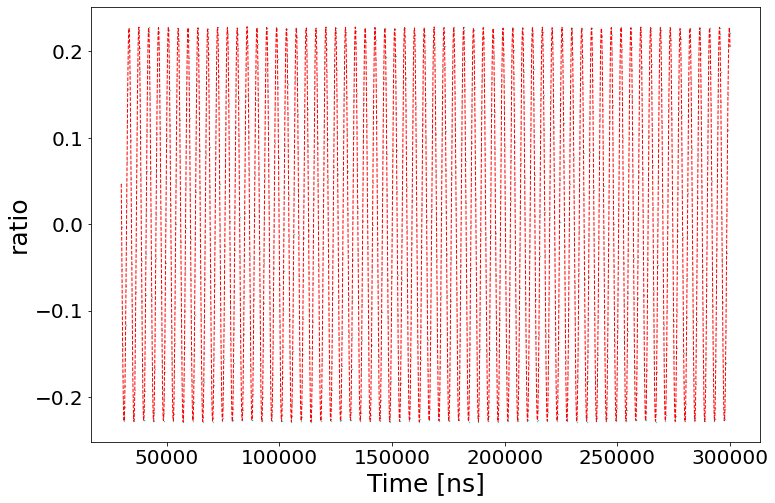

In [15]:
# Plot the noisy exponential data
plt.figure(figsize=(12,8))
plt.rc('xtick', labelsize=20) 
plt.rc('ytick', labelsize=20) 
plt.scatter(x_val, y_val, s=0.1, color='#00b3b3', label='Data')
plt.plot(x_val, fit_func(x_val, *pars_final), linestyle='--', linewidth=1, color='red')
plt.xlabel('Time [ns]',fontsize=25)
plt.ylabel('ratio',fontsize=25)
#plt.ylim([0.0, 6000000000])
#plt.xlim([100000,150000])
plt.show()

In [16]:
# Calculate the residuals
res = (y_val - fit_func(x_val, *pars_final))/y_err

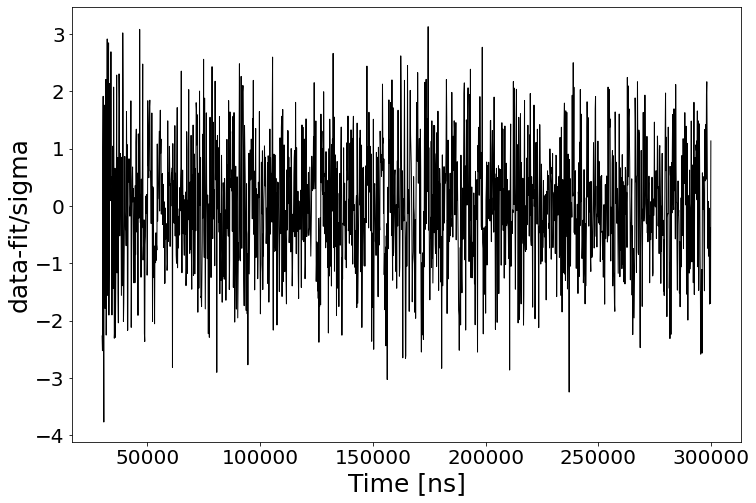

In [17]:
# Plot the noisy exponential data
plt.figure(figsize=(12,8))
plt.rc('xtick', labelsize=20) 
plt.rc('ytick', labelsize=20) 
plt.plot(x_val, res, linestyle='solid', linewidth=1, color='black')
plt.xlabel('Time [ns]',fontsize=25)
plt.ylabel('data-fit/sigma',fontsize=25)
plt.savefig('run2all_res.jpg')

In [18]:
stdevs

array([9.09564627e-06, 5.07062742e-01, 7.70692459e-05, 2.55110957e-05,
       8.73240508e+03, 1.27061250e-07, 1.06122383e-02, 7.67985580e-05,
       1.24482249e-01, 7.72603033e-05, 1.05898516e+00, 3.41236950e-05,
       5.25293323e+04, 2.14221959e-06, 1.79337917e-01, 2.20398747e-04,
       2.72494046e+03, 3.44024202e-06, 1.53089640e-01, 3.47825591e-05,
       5.88767563e+04, 3.62503952e-06, 2.48886708e-01])

In [19]:
fou=abs(np.fft.fft(res))

In [20]:
#xfft=np.empty(fit_range)
xfft= np.linspace(0,6.667,num=1801)
xfft[800]

2.963111111111111

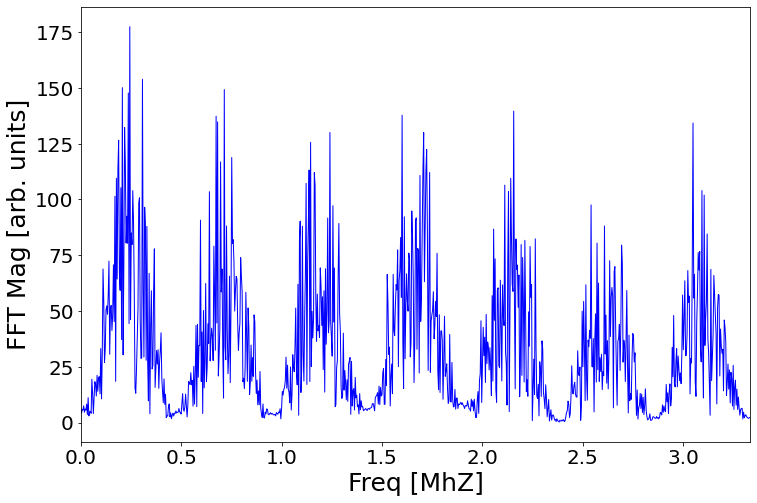

In [21]:
plt.figure(figsize=(12,8))
plt.rc('xtick', labelsize=20) 
plt.rc('ytick', labelsize=20) 
plt.plot(xfft, fou, linestyle='solid', linewidth=1, color='blue')
plt.xlim([0,6.667/2])
plt.xlabel('Freq [MhZ]',fontsize=25)
plt.ylabel('FFT Mag [arb. units]',fontsize=25)
plt.savefig('run2all_fft.jpg')

In [22]:
chi2=np.dot((np.transpose(y_val-fit_func(x_val, *pars_final))),(np.dot((np.linalg.inv(y_cov)),(y_val-fit_func(x_val, *pars_final)))))

In [23]:
chi2

1791.7882629474489

In [24]:
ndf=fit_range-23

In [25]:
red_chi2=chi2/ndf

In [26]:
red_chi2

1.0077549285418723